# CycleGAN

    CycleGANs learns to transform images from one sample into images that could seems reasonable similar to another sample.
    For example, a CycleGAN produced the right hand image below when given the left hand image as input. 
    It even took an image of a horse and turned it into an image of a zebra. 
    Our task is to produce images in the style of Monet using a random set of photos.

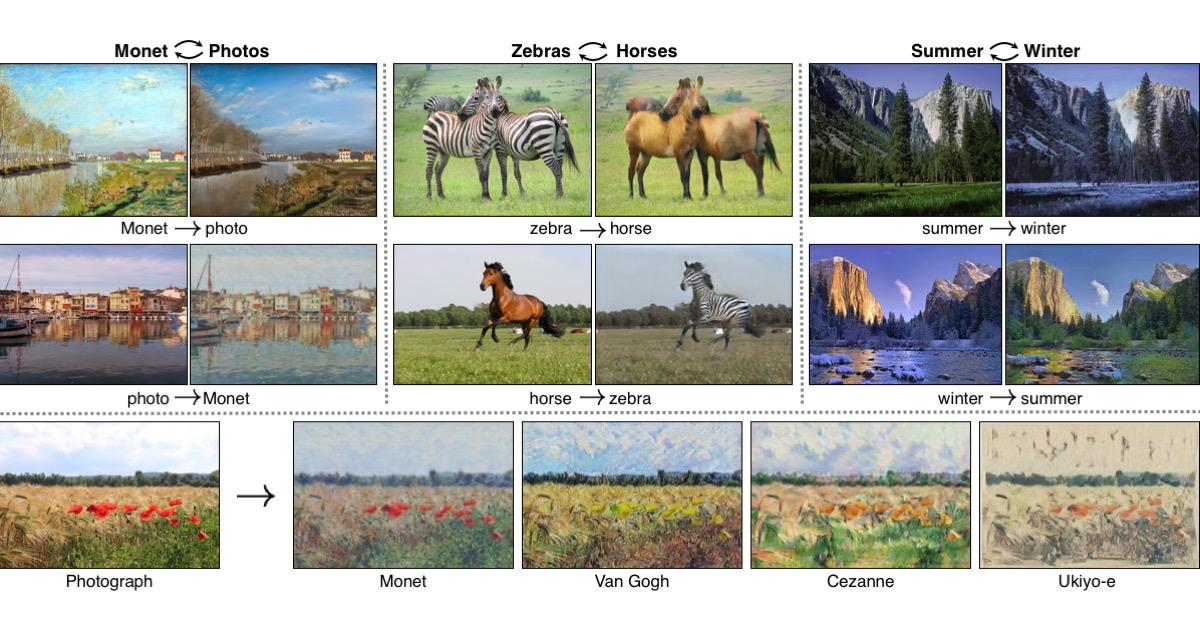


   ## Contents:
* <h1 style="padding: 1rem;
      color:black;
      text-align:left;
      margin:0 auto;
      font-size:1.5rem;"><a href="#config">Config</a></h1>
          
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#transform">Dataset Transform and Dataloader</a></h1>
          
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#discri">CycleGAN Discriminator</a></h1>
          
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#gener">CycleGAN Generator</a></h1>
          
* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#training">Training Loop</a></h1>

* <h1 style="padding: 1rem;
          color:black;
          text-align:left;
          margin:0 auto;
          font-size:1.5rem;"><a href="#submission">Inference and Submission</a></h1>

In [ ]:
import os
import cv2
import torch
import torch.nn as nn
import numpy as np
from PIL import Image
import shutil
import itertools
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.utils import make_grid

In [ ]:
BATCH_SIZE = 5
MONET_IMAGES_PATH = "/kaggle/input/gan-getting-started/monet_jpg"
TEST_IMAGES_PATH = "/kaggle/input/gan-getting-started/photo_jpg"

lr = 0.0001
beta1 = 0.5
beta2 = 0.996
n_epoches = 90
decay_epoch = 40
display_epoch = 25

<div class="alert alert-warning" role="alert">
<a id="transform"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Dataset Transform
</h1></a>
</div>

In [ ]:
transforms_dataset = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, directory_x, directory_y, test=False, transforms=None):
        self.transforms = transforms
        
        if test:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[250:]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[250:301]]
        else:
            self.monet_images_X = [directory_x + "/" + name for name in sorted(os.listdir(directory_x))[:250]]
            self.test_images_Y = [directory_y + "/" + name for name in sorted(os.listdir(directory_y))[:250]]
        
    def __len__(self):
        return len(self.monet_images_X)
    
    def __getitem__(self, index):
        x_img =  Image.open(self.monet_images_X[index])
        y_img =  Image.open(self.test_images_Y[index])
        
        if self.transforms is not None:
            x_img = self.transforms(x_img)
            y_img = self.transforms(y_img)
        return x_img, y_img

In [ ]:
train_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=False, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 3
)

test_loader = DataLoader(
    ImageDataset(directory_x=MONET_IMAGES_PATH, directory_y=TEST_IMAGES_PATH, test=True, transforms=transforms_dataset),
    batch_size = BATCH_SIZE,
    shuffle = False,
    num_workers = 3
)

<div class="alert alert-warning" role="alert">
<a id="discri"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 CycleGAN Discriminator
</h1></a>
</div>

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, in_channels):
        super(Discriminator, self).__init__()
        self.scale_factor = 16

        self.model = nn.Sequential(
            nn.Conv2d(in_channels, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ZeroPad2d((1,0,1,0)),
            nn.Conv2d(512, 1, 4, padding=1),
        )

    def forward(self, x):
        return self.model(x)
    

<div class="alert alert-warning" role="alert">
<a id="gener"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 CycleGAN Generator
</h1></a>
</div>

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_channels, in_channels, 3),
            nn.InstanceNorm2d(in_channels)
        )

    def forward(self, x):
        return x + self.block(x)

class GeneratorResNet(nn.Module):
    def __init__(self, in_channels, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()

        self.initial = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(in_channels, 64, 2 * in_channels + 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.downsample_blocks = nn.Sequential(
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.InstanceNorm2d(256),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(*[ResidualBlock(256) for _ in range(num_residual_blocks)])

        self.upsample_blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, stride=1, padding=1),
            nn.InstanceNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.InstanceNorm2d(64),
            nn.ReLU(inplace=True)
        )

        self.output = nn.Sequential(
            nn.ReflectionPad2d(in_channels),
            nn.Conv2d(64, in_channels, 2 * in_channels + 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.initial(x)
        x = self.downsample_blocks(x)
        x = self.residual_blocks(x)
        x = self.upsample_blocks(x)
        return self.output(x)


<div class="alert alert-warning" role="alert">
<a id="training"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Training Loop
</h1></a>
</div>

In [ ]:
G_XY = GeneratorResNet(3, num_residual_blocks=9)
D_Y = Discriminator(3)

G_YX = GeneratorResNet(3, num_residual_blocks=9)
D_X = Discriminator(3)

In [ ]:
# Check for CUDA availability and define the Tensor type accordingly
cuda_available = torch.cuda.is_available()
Tensor = torch.cuda.FloatTensor if cuda_available else torch.Tensor
print(f'CUDA Available: {cuda_available}')

# Transfer models to CUDA if available
models = [G_XY, D_Y, G_YX, D_X]
for model in models:
    if cuda_available:
        model.cuda()

gan_loss = nn.MSELoss().cuda()
cycle_loss = nn.L1Loss().cuda()
identity_loss = nn.L1Loss().cuda()

In [ ]:
optimizer_G = torch.optim.Adam(itertools.chain(G_XY.parameters(), G_YX.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_D_X = torch.optim.Adam(D_X.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D_Y = torch.optim.Adam(D_Y.parameters(), lr=lr, betas=(beta1, beta2))


In [ ]:
def learning_rate_decay(epoch, decay_start_epoch, total_epochs):
    if epoch < decay_start_epoch:
        return 1
    else:
        return 1 - (epoch - decay_start_epoch) / (total_epochs - decay_start_epoch)

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_X = torch.optim.lr_scheduler.LambdaLR(optimizer_D_X, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))
lr_scheduler_D_Y = torch.optim.lr_scheduler.LambdaLR(optimizer_D_Y, lr_lambda=lambda epoch: learning_rate_decay(epoch, decay_epoch, n_epoches))

In [ ]:
def sample_images(real_X, real_Y):    
    G_XY.eval()
    G_YX.eval()

    real_X = real_X.type(Tensor)
    fake_Y = G_XY(real_X).detach()

    real_Y = real_Y.type(Tensor)
    fake_X = G_YX(real_Y).detach()

    ncols = real_X.size(0)
    real_X_grid = make_grid(real_X, nrow=ncols, normalize=True)
    fake_Y_grid = make_grid(fake_Y, nrow=ncols, normalize=True)
    real_Y_grid = make_grid(real_Y, nrow=ncols, normalize=True)
    fake_X_grid = make_grid(fake_X, nrow=ncols, normalize=True)

    fig, axs = plt.subplots(2, 2, figsize=(8, 8))  

    axs[0, 0].imshow(real_X_grid.permute(1, 2, 0).cpu())
    axs[0, 0].set_title("Real Images from Domain X")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(fake_Y_grid.permute(1, 2, 0).cpu())
    axs[0, 1].set_title("Generated Images to Domain Y")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(real_Y_grid.permute(1, 2, 0).cpu())
    axs[1, 0].set_title("Real Images from Domain Y")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(fake_X_grid.permute(1, 2, 0).cpu())
    axs[1, 1].set_title("Generated Images to Domain X")
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)


In [ ]:
real_X, real_Y = next(iter(test_loader))
sample_images(real_X, real_Y)

In [ ]:
for epoch in range(n_epoches):
    for i, (real_X, real_Y) in enumerate(train_loader):
        real_X, real_Y = real_X.type(Tensor), real_Y.type(Tensor)
        out_shape = [real_X.size(0), 1, real_X.size(2) // D_X.scale_factor, real_X.size(3) // D_X.scale_factor]
        
        valid = torch.ones(out_shape).type(Tensor)
        fake = torch.zeros(out_shape).type(Tensor)
        
        # training generators
        G_XY.train()
        G_YX.train()
        
        optimizer_G.zero_grad()
        
        fake_Y = G_XY(real_X)
        fake_X = G_YX(real_Y)
        
        # identity loss
        loss_id_X = identity_loss(fake_Y, real_X)
        loss_id_Y = identity_loss(fake_X, real_Y)
        loss_identity = (loss_id_X + loss_id_Y) / 2
        
        # gan loss
        loss_GAN_XY = gan_loss(D_Y(fake_Y), valid) 
        loss_GAN_YX = gan_loss(D_X(fake_X), valid)
        loss_GAN = (loss_GAN_XY + loss_GAN_YX) / 2
        
        # cycle loss
        recov_X = G_YX(fake_Y)
        recov_Y = G_XY(fake_X)
        
        loss_cycle_X = cycle_loss(recov_X, real_X)
        loss_cycle_Y = cycle_loss(recov_Y, real_Y)
        loss_cycle = (loss_cycle_X + loss_cycle_Y) / 2
        
        # total gan loss
        loss_G = 5.0 * loss_identity + loss_GAN + 10.0 * loss_cycle
        
        loss_G.backward()
        optimizer_G.step()
        
        #training discriminator X
        optimizer_D_X.zero_grad()
        
        loss_real = gan_loss(D_X(real_X), valid)
        loss_fake = gan_loss(D_X(fake_X.detach()), fake)
        loss_D_X = (loss_real + loss_fake) / 2
        
        loss_D_X.backward()
        optimizer_D_X.step()
        
        #training discriminator Y
        optimizer_D_Y.zero_grad()
        
        loss_real = gan_loss(D_Y(real_Y), valid)
        loss_fake = gan_loss(D_Y(fake_Y.detach()), fake)
        loss_D_Y = (loss_real + loss_fake) / 2
        
        loss_D_Y.backward()
        optimizer_D_Y.step()
    
    lr_scheduler_G.step()
    lr_scheduler_D_X.step()
    lr_scheduler_D_Y.step()
    
    # display results every 20 epoch
    if (epoch + 1) % display_epoch == 0:
        test_real_X, test_real_Y = next(iter(test_loader))
        sample_images(test_real_X, test_real_Y)

        loss_D = (loss_D_X + loss_D_Y) / 2
        print(f'[Epoch {epoch + 1} / {n_epoches}]')
        print(f'[Generator loss: {loss_G.item()} | identity: {loss_identity.item()} GAN: {loss_GAN.item()} cycle: {loss_cycle.item()}]')
        print(f'[Discriminator loss: {loss_D.item()} | D_X: {loss_D_X.item()} D_Y: {loss_D_Y.item()}]')    

<div class="alert alert-warning" role="alert">
<a id="submission"><h1 style="padding: 2rem;
          color:black;
          text-align:center;
          margin:0 auto;
          font-size:2rem;">
 Inference and Submission
</h1></a>
</div>

In [ ]:
files = [TEST_IMAGES_PATH + "/" + name for name in os.listdir(TEST_IMAGES_PATH)]
len(files)

In [ ]:
save_dir = '../images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
transforms_dataset = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

tensor_to_image = transforms.ToPILImage()
G_YX.eval()

# Process images in batches
for batch_start in range(0, len(files), BATCH_SIZE):
    batch_files = files[batch_start:batch_start + BATCH_SIZE]
    batch_imgs = [transforms_dataset(Image.open(file)) for file in batch_files]
    
    batch_tensor = torch.stack(batch_imgs).type(Tensor)
    generated_imgs = G_YX(batch_tensor).detach().cpu()
    
    for idx, tensor_img in enumerate(generated_imgs):
        # Convert tensor to numpy array and normalize to range [0, 255]
        np_img = tensor_img.squeeze().permute(1, 2, 0).numpy()
        np_img = ((np_img - np_img.min()) * 255 / (np_img.max() - np_img.min())).astype(np.uint8)
        
        # Save the generated image
        pil_img = tensor_to_image(np_img)
        _, filename = os.path.split(files[batch_start + idx])
        pil_img.save(os.path.join(save_dir, filename))

In [ ]:
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")